# Random Seed

In [1]:
import random
import numpy as np
import torch


RANDOM_SEED = 17
COMPRESSION = 6


random.seed(RANDOM_SEED)

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Auto encoder

## Read data

In [ ]:
from data.data import listTurbines


turbines = listTurbines()
turbines

['CRKALN_001',
 'CRKALN_002',
 'CRKALN_003',
 'CRKALN_004',
 'CRKALN_005',
 'CRKALN_006',
 'CRKALN_007',
 'CRKALN_008',
 'CRKALN_009',
 'CRKALN_010']

In [ ]:
from preprocess.transform_data import TurbineData


turbineData = TurbineData(turbines[1], verbose=False)
print(turbineData.data3d.shape)
print(turbineData.columns)

(99264, 96, 28)
Index(['datetime', 'avgwindspeed', 'avgpower', 'windspeedstandarddeviation',
       'nacelleposition', 'avgwinddirection', 'availablepowerpublished',
       'avgrotorspeed', 'avgpitchangle', 'avgreactivepower',
       'ambienttemperature', 'avghumidity', 'turbinepressure', 'density',
       'latitude', 'longitude', 'cutoutwindspeed', 'ratedwindspeed',
       'rotordiameter', 'hubheight', 'groundlevelaltitude', 'turbulent',
       'underperformanceprobability', 'overperformanceprobability',
       'turbulentvalid', 'underperformanceprobabilityvalid',
       'overperformanceprobabilityvalid', 'original_feature_count'],
      dtype='object')


### Filter valid data

In [4]:
turbineData.verbose = True
normalIndices = turbineData.getNormalIndices(
    maxConsecutiveInvalid=0,  # 1 hours of consecutive invalid data
    maxInvalidRate=0.5,
    underperformThreshold=1,  # ignore underperf threshold
)

Valid: 8946
Not underperform: 99264
Normal: 8946


## Split train test

In [5]:
import numpy as np


TEST_RATIO = 0.2
VAL_RATIO = 0.2


# suffle data
np.random.shuffle(normalIndices)

# split data
n_test = int(len(normalIndices) * TEST_RATIO)
testIndices = normalIndices[:n_test]
trainIndices = normalIndices[n_test:]

n_val = int(len(trainIndices) * VAL_RATIO)
valIndices = trainIndices[:n_val]
trainIndices = trainIndices[n_val:]

print(f"Train: {len(trainIndices)} Val: {len(valIndices)} Test: {len(testIndices)}")

Train: 5726 Val: 1431 Test: 1789


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader

from preprocess.cls_dataset import toTurbineDatasets


tagetFeatRange = {
    "avgpower": [0, 2000],
    "avgrotorspeed": [0, 18],
    "avgwindspeed": [0, 25],
    "density": [0, 1.3],
    "ambienttemperature": [-5, 30],
    "avgwinddirection": [0, 360],
}

targetFeats = [k for k in tagetFeatRange.keys()]
immuteFeats = [
    "datetime",
    "underperformanceprobability",
]


# train the transformer
scaler = MinMaxScaler()
n_features = len(tagetFeatRange)
scaler.fit(np.zeros((1, n_features)))

# populate the scaler with the min and max values
scaler.data_min_ = np.array([v[0] for v in tagetFeatRange.values()])
scaler.data_max_ = np.array([v[1] for v in tagetFeatRange.values()])
scaler.data_range_ = scaler.data_max_ - scaler.data_min_
scaler.feature_names_in__ = np.array(targetFeats)  # type: ignore
scaler.scale_ = 1 / scaler.data_range_

indexer, (trainSet, valSet, testSet) = toTurbineDatasets(
    turbineData,
    (trainIndices, valIndices, testIndices),  # type: ignore
    targetFeats,
    scaler.transform,
    immuteFeats,
)

# trainSet.save("tmp/trainSet")
# valSet.save("tmp/valSet")
# testSet.save("tmp/testSet")


# from cls_dataset import TurbineDataset


# trainSet = TurbineDataset.load("tmp/trainSet")
# valSet = TurbineDataset.load("tmp/valSet")
# testSet = TurbineDataset.load("tmp/testSet")

# with open("./train.log", "w") as f:
#     print(trainSet[0][0], file=f)

trainLoader = DataLoader(trainSet, batch_size=64, shuffle=True, pin_memory=True)
valLoader = DataLoader(valSet, batch_size=64, shuffle=False, pin_memory=True)
testLoader = DataLoader(testSet, batch_size=64, shuffle=False, pin_memory=True)

first_batch = next(iter(trainLoader)).permute(0, 2, 1)
inputShape = np.array(first_batch[0].size())
inputShape[0] = len(targetFeats)

print(f"inputShape: {inputShape}")

inputShape: [ 6 96]


## Validate model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # noqa: F401
from torchsummary import summary

from model_options.mobilenet import MobileNetAutoencoder


# test if the model is working
testModel = MobileNetAutoencoder(
    inputShape, inputShape[0] * inputShape[1] // COMPRESSION
)

summary(testModel, torch.Size(inputShape), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 48]             288
       BatchNorm1d-2               [-1, 16, 48]              32
         Hardswish-3               [-1, 16, 48]               0
            Conv1d-4               [-1, 16, 48]             256
       BatchNorm1d-5               [-1, 16, 48]              32
              ReLU-6               [-1, 16, 48]               0
              ReLU-7               [-1, 16, 48]               0
              ReLU-8               [-1, 16, 48]               0
              ReLU-9               [-1, 16, 48]               0
           Conv1d-10               [-1, 16, 24]              48
      BatchNorm1d-11               [-1, 16, 24]              32
             ReLU-12               [-1, 16, 24]               0
             ReLU-13               [-1, 16, 24]               0
             ReLU-14               [-1,

## Training 

### Train Injections

In [9]:
def inferBatch(batch, model):

    # reshapre to (batch, feats as channels, timesteps)
    imm = batch[:, :, indexer.getItems(immuteFeats)].permute(0, 2, 1)
    inp = batch[:, :, indexer.getItems(targetFeats)].permute(0, 2, 1)

    out = model(inp)

    return torch.cat((out, imm), dim=1), torch.cat((inp, imm), dim=1)

In [10]:
def weightCal(pred, actual):
    underPerfProba = pred[
        :, indexer.getItem("underperformanceprobability"), :
    ].unsqueeze(1)
    underPerfProba = torch.clamp(underPerfProba, min=0.0, max=1.0)
    underPerfProba = torch.nan_to_num(underPerfProba, nan=0.0, posinf=1, neginf=0.0)
    weight = 1 - underPerfProba

    return weight

### Loop

In [ ]:
from matplotlib import pyplot as plt
import torch.optim as optim

from train.loss import TargetedLoss, WeightedLoss
from train.trainer import train


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


model = MobileNetAutoencoder(inputShape, inputShape[0] * inputShape[1] // COMPRESSION)
rawLoss = nn.MSELoss(reduction="none")
criterion = WeightedLoss(
    TargetedLoss(rawLoss, indexer.getItems(targetFeats)),
    # set weight to smallest proba that machine is working normaly
    weightCal=weightCal,
)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
earlyStopping = 10

trainLosses = []
valLosses = []

model, trainLosses, valLosses = train(
    model,
    device,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    epochs=num_epochs,
    earlyStopping=earlyStopping,
    inferBatch=inferBatch,
)

Device: cuda
Epoch 1/500 Train Loss: 0.1021 Val Loss: 0.0941
Epoch 2/500 Train Loss: 0.0226 Val Loss: 0.0419
Epoch 3/500 Train Loss: 0.0110 Val Loss: 0.0249
Epoch 4/500 Train Loss: 0.0100 Val Loss: 0.0236
Epoch 5/500 Train Loss: 0.0090 Val Loss: 0.0216
Epoch 6/500 Train Loss: 0.0081 Val Loss: 0.0151
Epoch 7/500 Train Loss: 0.0077 Val Loss: 0.4349
Epoch 8/500 Train Loss: 0.0072 Val Loss: 0.0186
Epoch 9/500 Train Loss: 0.0068 Val Loss: 0.0143
Epoch 10/500 Train Loss: 0.0066 Val Loss: 0.1549
Epoch 11/500 Train Loss: 0.0064 Val Loss: 0.1323
Epoch 12/500 Train Loss: 0.0062 Val Loss: 0.1211
Epoch 13/500 Train Loss: 0.0063 Val Loss: 0.0495
Epoch 14/500 Train Loss: 0.0061 Val Loss: 0.0230
Epoch 15/500 Train Loss: 0.0059 Val Loss: 0.0156
Epoch 16/500 Train Loss: 0.0058 Val Loss: 0.0125
Epoch 17/500 Train Loss: 0.0057 Val Loss: 0.0183
Epoch 18/500 Train Loss: 0.0056 Val Loss: 0.0127
Epoch 19/500 Train Loss: 0.0056 Val Loss: 0.0094
Epoch 20/500 Train Loss: 0.0055 Val Loss: 0.0067
Epoch 21/500 Tra

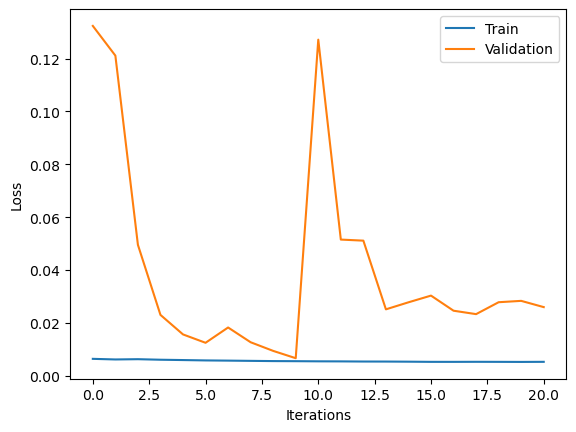

In [12]:
plt.xlabel("Iterations")
plt.ylabel("Loss")


plt.plot(trainLosses[10:])
plt.plot(valLosses[10:])

# plt.ylim(-0, 0.01)

plt.legend(["Train", "Validation"])
plt.show()

## Evaluating

In [ ]:
from train.trainer import infer


org = []
reconst = []

rotIn = []
rotOut = []

dateIn = []

testLoss = 0

model.eval()
outputs, actual = infer(model, device, testLoader, inferBatch)

testLoss = criterion(outputs, actual).item()
print(f"Test loss: {testLoss:.4f}")

Test loss: 0.0217


In [14]:
for feat in targetFeats:
    featIndex = indexer[feat]
    featLoss = (
        rawLoss(
            outputs[:, featIndex : (featIndex + 1), :],
            actual[:, featIndex : (featIndex + 1), :],
        )
        .mean()
        .item()
    )
    print(f"Loss for {feat}: {featLoss:.4f}")

Loss for avgpower: 0.0640
Loss for avgrotorspeed: 0.0278
Loss for avgwindspeed: 0.0063
Loss for density: 0.1215
Loss for ambienttemperature: 0.0160
Loss for avgwinddirection: 0.0772


In [15]:
targetFeats

['avgpower',
 'avgrotorspeed',
 'avgwindspeed',
 'density',
 'ambienttemperature',
 'avgwinddirection']

### Reconstruct graph

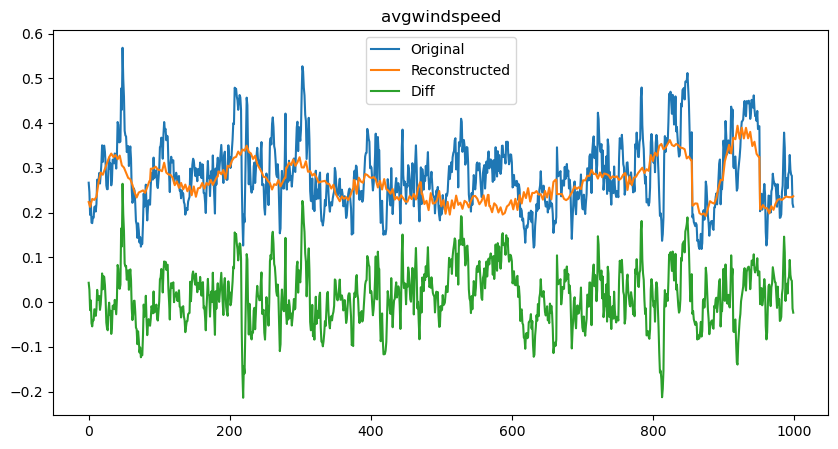

In [16]:
a = 5000
b = a + 1000
featName = "avgwindspeed"
featIdx = indexer[featName]

org = actual[:, featIdx, :].detach().cpu().numpy().reshape(-1)
reconst = outputs[:, featIdx, :].detach().cpu().numpy().reshape(-1)

plt.figure(figsize=(10, 5))
plt.plot(org[a:b], label="Original")
plt.plot(reconst[a:b], label="Reconstructed")
plt.plot(org[a:b] - reconst[a:b], label="Diff")
plt.legend()
plt.title(featName)
plt.show()

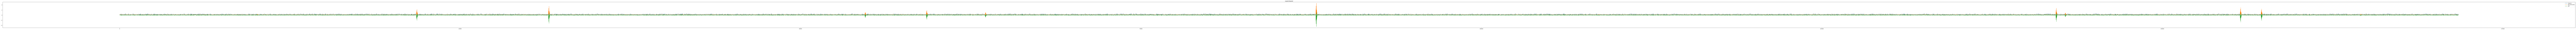

In [17]:
plt.figure(figsize=(500, 5))
plt.plot(org, label="Original")
plt.plot(reconst, label="Reconstructed")
plt.plot(org - reconst, label="Diff")
plt.legend()
plt.title(featName)
plt.savefig(f"output/{featName}.pdf")

In [18]:
diff = org - reconst
diff.mean(), diff.std(), diff.max(), diff.min()

(np.float32(0.0059437305),
 np.float32(0.07912568),
 np.float32(1.0480862),
 np.float32(-4.4976068))

In [19]:
sortedOrg, sortedReconst = zip(*sorted(zip(org, reconst)))

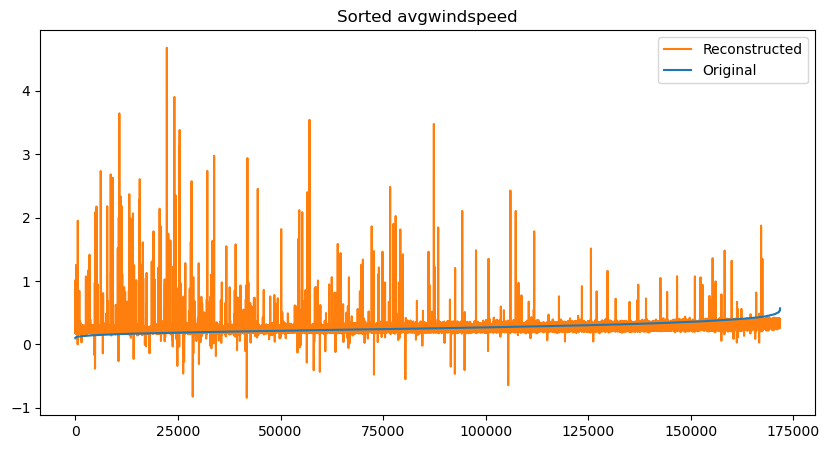

In [20]:
a = 0
b = len(org)

plt.figure(figsize=(10, 5))
plt.plot(sortedReconst[a:b], label="Reconstructed", color="#ff7f0e")
plt.plot(sortedOrg[a:b], label="Original", color="#1f77b4")
plt.title(f"Sorted {featName}")
plt.legend()
plt.show()

# [scatter] Real vs. predicted

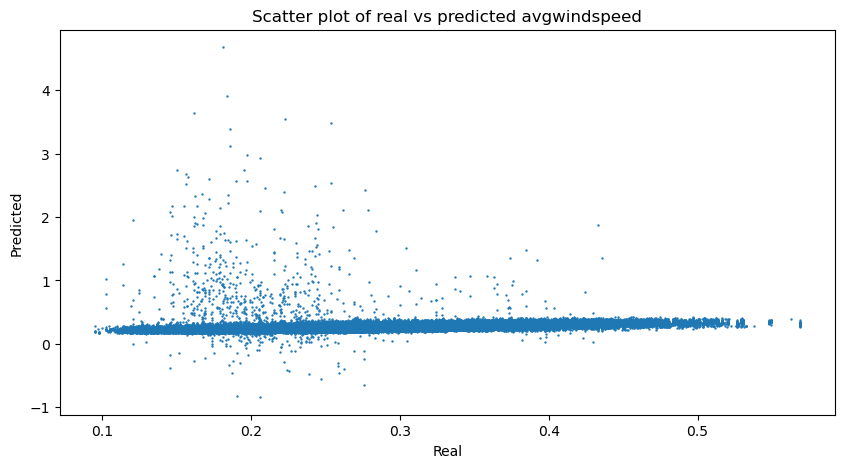

In [21]:
# scratter plot of real vs predicted
plt.figure(figsize=(10, 5))
plt.scatter(org, reconst, s=0.5)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title(f"Scatter plot of real vs predicted {featName}")
plt.show()

# [line] Error (either MAE or MSE) through time (aggregate weekly or monthly to ease visualization)

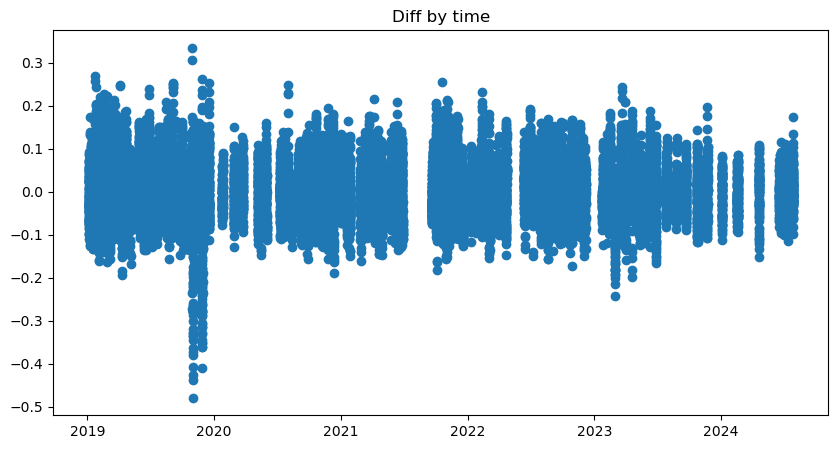

Unknown time: 0


In [22]:
import datetime


timeFeat = actual[:, indexer["datetime"], :].detach().cpu().numpy().reshape(-1)
diff = org - reconst

sortedTime, diffByTime = zip(*sorted(zip(timeFeat, diff)))

map = {}
unkTime = 0
for value, timeFeat in zip(diffByTime, sortedTime):
    try:
        time = datetime.datetime.fromtimestamp(int(timeFeat))
    except ValueError:
        unkTime += 1
        continue

    if time not in map:
        map[time] = (value, 1)
    else:
        map[time] = (map[time][0] + value, map[time][1] + 1)

diffByTime = [value / count for value, count in map.values()]
timeUniq = list(map.keys())

plt.figure(figsize=(10, 5))
plt.scatter(timeUniq, diffByTime)
plt.title("Diff by time")
plt.show()
print(f"Unknown time: {unkTime}")

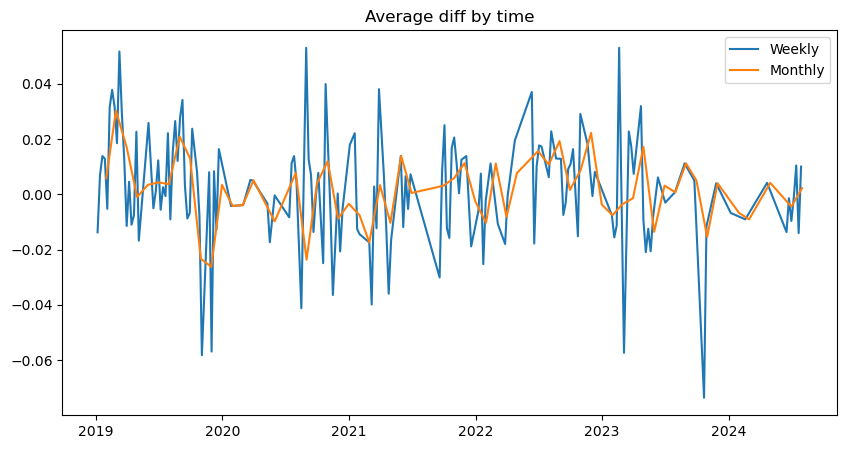

In [23]:
import pandas as pd


dfDiff = pd.DataFrame({"time": timeUniq, "diff": diffByTime})
dfDiff.to_csv("output/diff_temp_by_time.csv")
# dfDiff = pd.read_csv("output/diff_temp_by_time.csv")
# dfDiff["time"] = pd.to_datetime(dfDiff["time"])

dfWeek = dfDiff.resample("W", on="time").mean()
dfWeek = dfWeek.dropna()
dfMonth = dfDiff.resample("ME", on="time").mean()
dfMonth = dfMonth.dropna()

plt.figure(figsize=(10, 5))
plt.plot(dfWeek["diff"], label="Weekly")
plt.plot(dfMonth["diff"], label="Monthly")
plt.legend()
plt.title("Average diff by time")
plt.show()

# [scatter] Error vs. underperformance probability

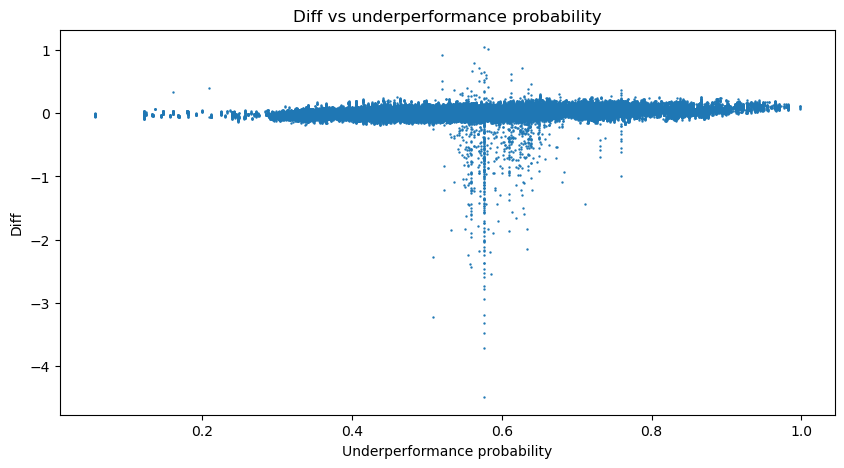

In [24]:
org = actual[:, featIdx].detach().cpu().numpy().reshape(-1)
reconst = outputs[:, featIdx].detach().cpu().numpy().reshape(-1)
diff = org - reconst

underProba = (
    actual[:, indexer["underperformanceprobability"]].detach().cpu().numpy().reshape(-1)
)

plt.figure(figsize=(10, 5))
plt.scatter(underProba, diff, s=0.5)
plt.xlabel("Underperformance probability")
plt.ylabel("Diff")
plt.title("Diff vs underperformance probability")
plt.savefig("output/diff_vs_underperformance.pdf")
plt.show()

# End

In [25]:
turbineData.close()